## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 4
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:01<00:00, 100398666.97it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch4-768d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch4-768d-12h-12l_CIFAR100.pt",
)


# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [04:24<00:00,  5.92it/s]


Epoch : 1 - acc: 0.0828 - loss : 4.0700



100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


test acc: 0.1222 - test loss : 3.8016



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 2 - acc: 0.1276 - loss : 3.7163



100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


test acc: 0.1548 - test loss : 3.5518



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 3 - acc: 0.1653 - loss : 3.5239



100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


test acc: 0.1805 - test loss : 3.4042



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 4 - acc: 0.1842 - loss : 3.3818



100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


test acc: 0.2025 - test loss : 3.2839



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 5 - acc: 0.2068 - loss : 3.2677



100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


test acc: 0.2345 - test loss : 3.1603



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 6 - acc: 0.2209 - loss : 3.1831



100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


test acc: 0.2482 - test loss : 3.0904



100%|██████████| 1563/1563 [04:39<00:00,  5.60it/s]


Epoch : 7 - acc: 0.2357 - loss : 3.0950



100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


test acc: 0.2540 - test loss : 3.0557



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 8 - acc: 0.2505 - loss : 3.0373



100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


test acc: 0.2616 - test loss : 2.9871



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 9 - acc: 0.2602 - loss : 2.9791



100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


test acc: 0.2681 - test loss : 2.9375



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 10 - acc: 0.2689 - loss : 2.9298



100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


test acc: 0.2790 - test loss : 2.9089



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 11 - acc: 0.2803 - loss : 2.8771



100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


test acc: 0.2883 - test loss : 2.8894



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 12 - acc: 0.2858 - loss : 2.8321



100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


test acc: 0.2915 - test loss : 2.8516



100%|██████████| 1563/1563 [04:36<00:00,  5.64it/s]


Epoch : 13 - acc: 0.2969 - loss : 2.7828



100%|██████████| 313/313 [00:19<00:00, 16.25it/s]


test acc: 0.3078 - test loss : 2.7980



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 14 - acc: 0.3020 - loss : 2.7528



100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


test acc: 0.3144 - test loss : 2.7606



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 15 - acc: 0.3086 - loss : 2.7175



100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


test acc: 0.3135 - test loss : 2.7470



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 16 - acc: 0.3159 - loss : 2.6854



100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


test acc: 0.3100 - test loss : 2.7460



100%|██████████| 1563/1563 [04:37<00:00,  5.62it/s]


Epoch : 17 - acc: 0.3234 - loss : 2.6531



100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


test acc: 0.3221 - test loss : 2.7298



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 18 - acc: 0.3283 - loss : 2.6181



100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


test acc: 0.3181 - test loss : 2.7190



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 19 - acc: 0.3352 - loss : 2.5867



100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


test acc: 0.3254 - test loss : 2.6797



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 20 - acc: 0.3423 - loss : 2.5529



100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


test acc: 0.3283 - test loss : 2.6842



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 21 - acc: 0.3490 - loss : 2.5366



100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


test acc: 0.3371 - test loss : 2.6499



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 22 - acc: 0.3525 - loss : 2.5023



100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


test acc: 0.3385 - test loss : 2.6542



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 23 - acc: 0.3572 - loss : 2.4819



100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


test acc: 0.3421 - test loss : 2.6318



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 24 - acc: 0.3609 - loss : 2.4636



100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


test acc: 0.3443 - test loss : 2.6379



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 25 - acc: 0.3673 - loss : 2.4379



100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


test acc: 0.3550 - test loss : 2.5971



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 26 - acc: 0.3737 - loss : 2.4013



100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


test acc: 0.3486 - test loss : 2.6016



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 27 - acc: 0.3774 - loss : 2.3794



100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


test acc: 0.3567 - test loss : 2.5570



100%|██████████| 1563/1563 [04:38<00:00,  5.60it/s]


Epoch : 28 - acc: 0.3824 - loss : 2.3627



100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


test acc: 0.3529 - test loss : 2.5755



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 29 - acc: 0.3888 - loss : 2.3324



100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


test acc: 0.3550 - test loss : 2.5692



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 30 - acc: 0.3910 - loss : 2.3160



100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


test acc: 0.3675 - test loss : 2.5512



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 31 - acc: 0.3965 - loss : 2.3004



100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


test acc: 0.3584 - test loss : 2.5733



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 32 - acc: 0.4008 - loss : 2.2772



100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


test acc: 0.3594 - test loss : 2.5670



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 33 - acc: 0.4017 - loss : 2.2636



100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


test acc: 0.3627 - test loss : 2.5355



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 34 - acc: 0.4107 - loss : 2.2285



100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


test acc: 0.3720 - test loss : 2.5506



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 35 - acc: 0.4137 - loss : 2.2153



100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


test acc: 0.3709 - test loss : 2.5306



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 36 - acc: 0.4152 - loss : 2.2008



100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


test acc: 0.3696 - test loss : 2.5223



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 37 - acc: 0.4177 - loss : 2.1819



100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


test acc: 0.3723 - test loss : 2.5496



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 38 - acc: 0.4225 - loss : 2.1718



100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


test acc: 0.3696 - test loss : 2.5301



100%|██████████| 1563/1563 [04:38<00:00,  5.60it/s]


Epoch : 39 - acc: 0.4270 - loss : 2.1458



100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


test acc: 0.3746 - test loss : 2.5429



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 40 - acc: 0.4311 - loss : 2.1352



100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


test acc: 0.3749 - test loss : 2.5163



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 41 - acc: 0.4338 - loss : 2.1139



100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


test acc: 0.3871 - test loss : 2.4883



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 42 - acc: 0.4376 - loss : 2.0945



100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


test acc: 0.3720 - test loss : 2.5322



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 43 - acc: 0.4404 - loss : 2.0897



100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


test acc: 0.3798 - test loss : 2.5067



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 44 - acc: 0.4418 - loss : 2.0714



100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


test acc: 0.3831 - test loss : 2.5062



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 45 - acc: 0.4483 - loss : 2.0517



100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


test acc: 0.3809 - test loss : 2.5042



100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


Epoch : 46 - acc: 0.4518 - loss : 2.0327



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3885 - test loss : 2.4935



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 47 - acc: 0.4547 - loss : 2.0191



100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


test acc: 0.3875 - test loss : 2.5187



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 48 - acc: 0.4567 - loss : 2.0032



100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


test acc: 0.3864 - test loss : 2.4888



100%|██████████| 1563/1563 [04:36<00:00,  5.64it/s]


Epoch : 49 - acc: 0.4600 - loss : 1.9883



100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


test acc: 0.3825 - test loss : 2.5295



100%|██████████| 1563/1563 [04:38<00:00,  5.62it/s]


Epoch : 50 - acc: 0.4613 - loss : 1.9829



100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


test acc: 0.3888 - test loss : 2.4983



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 51 - acc: 0.4640 - loss : 1.9737



100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


test acc: 0.3862 - test loss : 2.4968



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 52 - acc: 0.4660 - loss : 1.9544



100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


test acc: 0.3852 - test loss : 2.5150



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 53 - acc: 0.4744 - loss : 1.9296



100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


test acc: 0.3839 - test loss : 2.4856



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 54 - acc: 0.4756 - loss : 1.9195



100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


test acc: 0.3865 - test loss : 2.5076



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 55 - acc: 0.4761 - loss : 1.9184



100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


test acc: 0.3898 - test loss : 2.5105



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 56 - acc: 0.4777 - loss : 1.9059



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3908 - test loss : 2.4913



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 57 - acc: 0.4808 - loss : 1.8956



100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


test acc: 0.3892 - test loss : 2.5128



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 58 - acc: 0.4861 - loss : 1.8705



100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


test acc: 0.3856 - test loss : 2.5138



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 59 - acc: 0.4895 - loss : 1.8516



100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


test acc: 0.3909 - test loss : 2.5188



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 60 - acc: 0.4922 - loss : 1.8427



100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


test acc: 0.3878 - test loss : 2.5464



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 61 - acc: 0.4952 - loss : 1.8326



100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


test acc: 0.3904 - test loss : 2.5383



100%|██████████| 1563/1563 [04:36<00:00,  5.64it/s]


Epoch : 62 - acc: 0.4968 - loss : 1.8319



100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


test acc: 0.3845 - test loss : 2.5312



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 63 - acc: 0.4988 - loss : 1.8051



100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


test acc: 0.3924 - test loss : 2.5113



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 64 - acc: 0.5043 - loss : 1.7950



100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


test acc: 0.3914 - test loss : 2.5343



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 65 - acc: 0.5023 - loss : 1.7852



100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


test acc: 0.3887 - test loss : 2.5731



100%|██████████| 1563/1563 [04:36<00:00,  5.64it/s]


Epoch : 66 - acc: 0.5026 - loss : 1.7844



100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


test acc: 0.3800 - test loss : 2.6009



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 67 - acc: 0.5091 - loss : 1.7618



100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


test acc: 0.3908 - test loss : 2.5546



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 68 - acc: 0.5132 - loss : 1.7504



100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


test acc: 0.3941 - test loss : 2.5549



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 69 - acc: 0.5191 - loss : 1.7260



100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


test acc: 0.3928 - test loss : 2.5446



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 70 - acc: 0.5143 - loss : 1.7345



100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


test acc: 0.3868 - test loss : 2.5714



100%|██████████| 1563/1563 [04:36<00:00,  5.64it/s]


Epoch : 71 - acc: 0.5193 - loss : 1.7200



100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


test acc: 0.3924 - test loss : 2.5636



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 72 - acc: 0.5267 - loss : 1.6954



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3920 - test loss : 2.5715



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 73 - acc: 0.5255 - loss : 1.6910



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3899 - test loss : 2.5739



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 74 - acc: 0.5281 - loss : 1.6817



100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


test acc: 0.3911 - test loss : 2.5756



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 75 - acc: 0.5273 - loss : 1.6885



100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


test acc: 0.3889 - test loss : 2.5822



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 76 - acc: 0.5281 - loss : 1.6777



100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


test acc: 0.3885 - test loss : 2.6040



100%|██████████| 1563/1563 [04:37<00:00,  5.64it/s]


Epoch : 77 - acc: 0.5332 - loss : 1.6595



100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


test acc: 0.3896 - test loss : 2.6039



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 78 - acc: 0.5383 - loss : 1.6445



100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


test acc: 0.3928 - test loss : 2.6401



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 79 - acc: 0.5378 - loss : 1.6397



100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


test acc: 0.3911 - test loss : 2.6098



100%|██████████| 1563/1563 [04:37<00:00,  5.63it/s]


Epoch : 80 - acc: 0.5364 - loss : 1.6360



100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


test acc: 0.3886 - test loss : 2.6000



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 81 - acc: 0.5364 - loss : 1.6535



100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


test acc: 0.3904 - test loss : 2.6342



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 82 - acc: 0.5376 - loss : 1.6320



100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


test acc: 0.3859 - test loss : 2.6483



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 83 - acc: 0.5422 - loss : 1.6244



100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


test acc: 0.3906 - test loss : 2.6301



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 84 - acc: 0.5439 - loss : 1.6095



100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


test acc: 0.3845 - test loss : 2.6407



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 85 - acc: 0.5469 - loss : 1.5967



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3913 - test loss : 2.6221



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 86 - acc: 0.5521 - loss : 1.5782



100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


test acc: 0.3875 - test loss : 2.6676



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 87 - acc: 0.5514 - loss : 1.5721



100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


test acc: 0.3885 - test loss : 2.6396



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 88 - acc: 0.5562 - loss : 1.5568



100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


test acc: 0.3906 - test loss : 2.6355



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 89 - acc: 0.5567 - loss : 1.5614



100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


test acc: 0.3925 - test loss : 2.6704



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 90 - acc: 0.5560 - loss : 1.5545



100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


test acc: 0.3811 - test loss : 2.7008



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 91 - acc: 0.5575 - loss : 1.5547



100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


test acc: 0.3892 - test loss : 2.6993



100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s]


Epoch : 92 - acc: 0.5584 - loss : 1.5378



100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


test acc: 0.3887 - test loss : 2.7104



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 93 - acc: 0.5617 - loss : 1.5278



100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


test acc: 0.3851 - test loss : 2.6580



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 94 - acc: 0.5660 - loss : 1.5088



100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


test acc: 0.3823 - test loss : 2.7066



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 95 - acc: 0.5656 - loss : 1.5203



100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


test acc: 0.3876 - test loss : 2.7039



100%|██████████| 1563/1563 [04:35<00:00,  5.66it/s]


Epoch : 96 - acc: 0.5690 - loss : 1.4991



100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


test acc: 0.3869 - test loss : 2.7371



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 97 - acc: 0.5796 - loss : 1.4643



100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


test acc: 0.3953 - test loss : 2.7282



100%|██████████| 1563/1563 [04:35<00:00,  5.68it/s]


Epoch : 98 - acc: 0.5770 - loss : 1.4669



100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


test acc: 0.3894 - test loss : 2.7192



100%|██████████| 1563/1563 [04:36<00:00,  5.66it/s]


Epoch : 99 - acc: 0.5786 - loss : 1.4565



100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


test acc: 0.3924 - test loss : 2.6946



100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Epoch : 100 - acc: 0.5797 - loss : 1.4618



100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


test acc: 0.3885 - test loss : 2.7148

Start Time: 1734774364.304856
End Time: 1734804032.289104
Time Taken: 29667.984247922897 seconds


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

<ipython-input-13-053996e4518c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


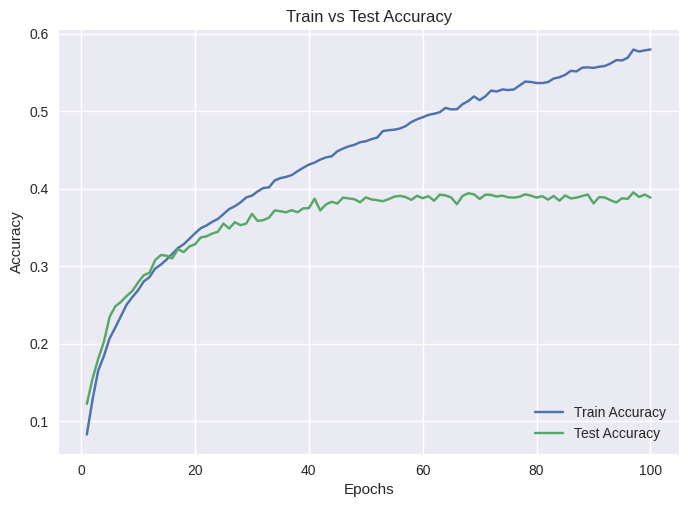

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:18<00:00, 16.99it/s]


####  Superclass confusion matrix

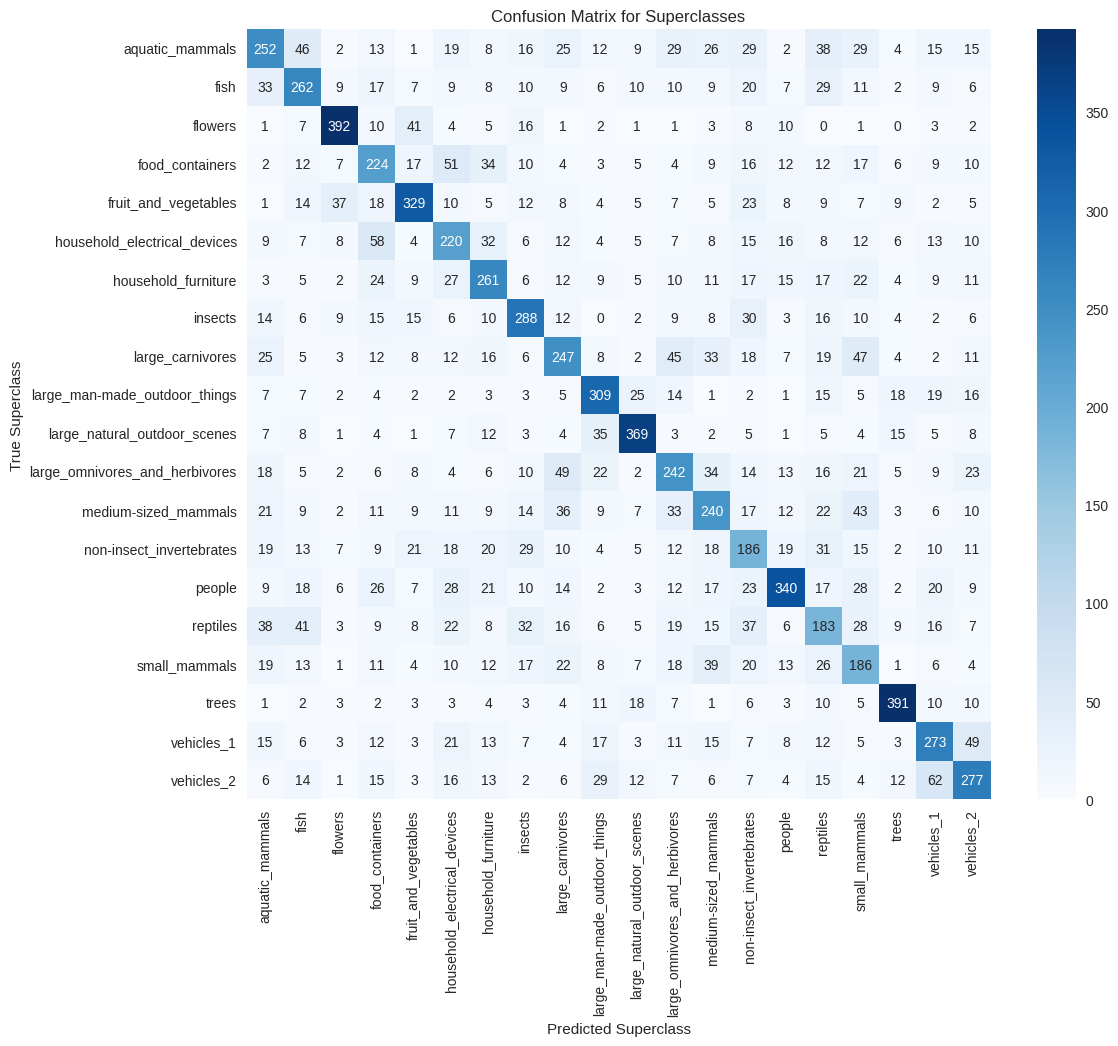

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

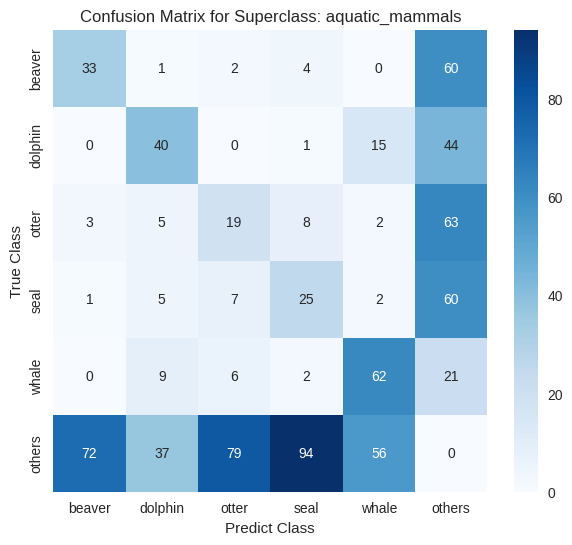

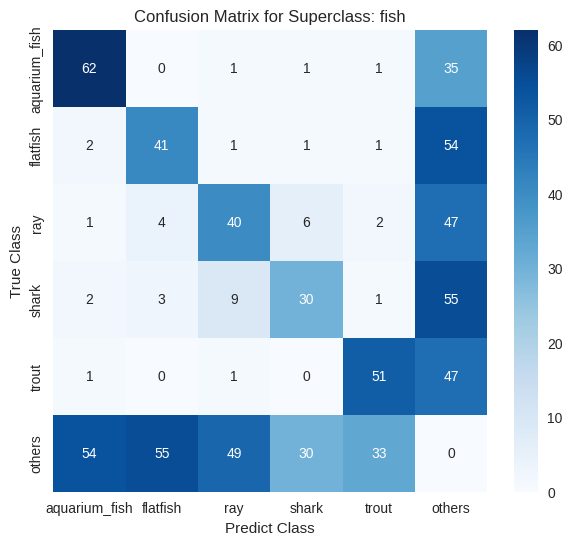

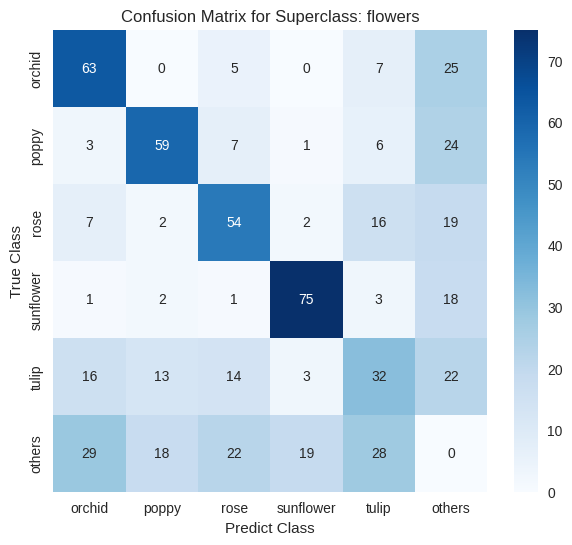

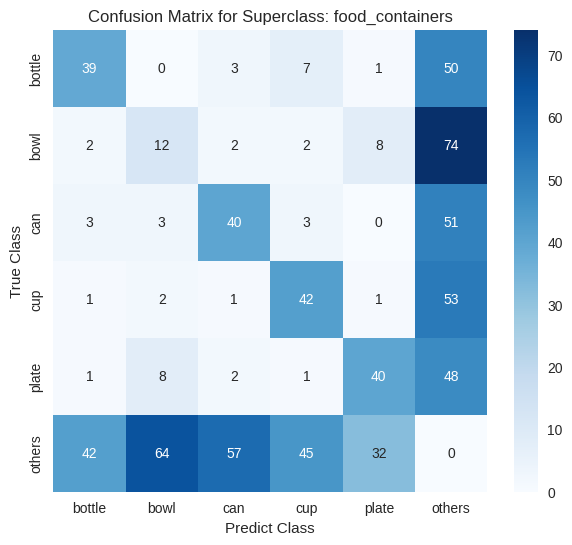

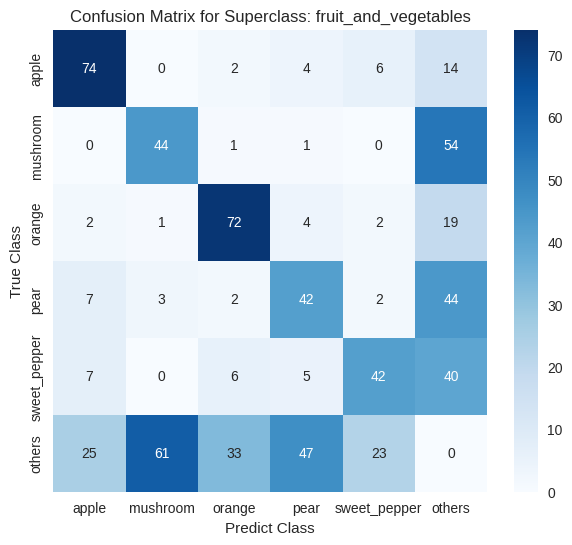

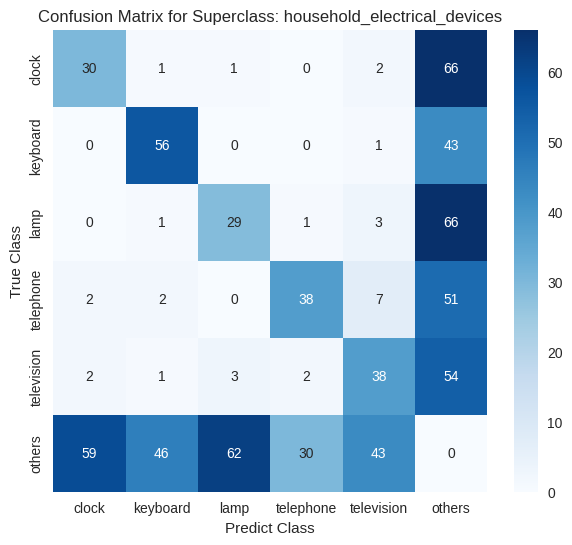

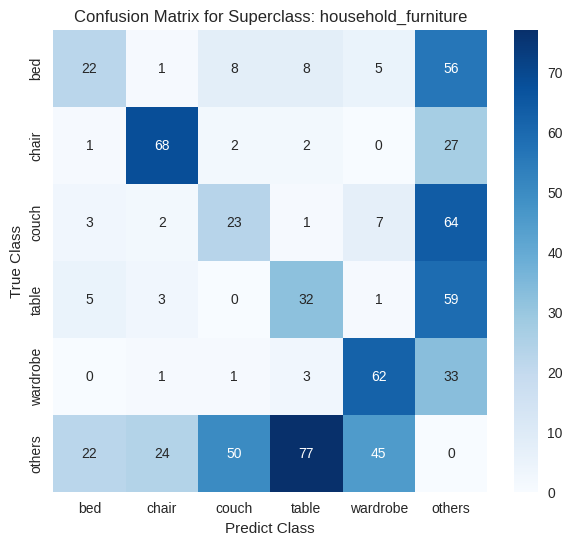

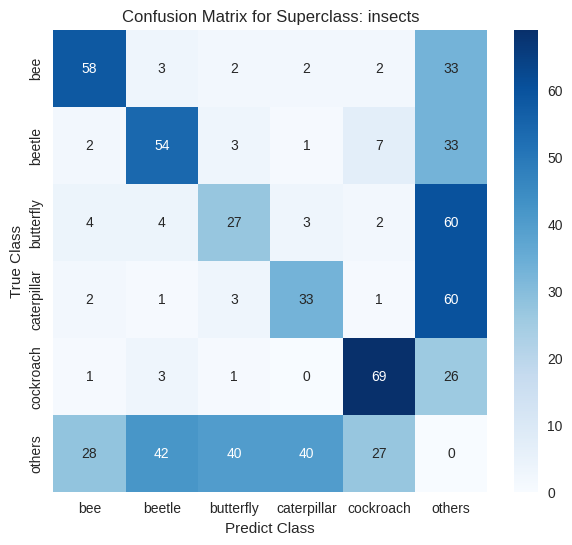

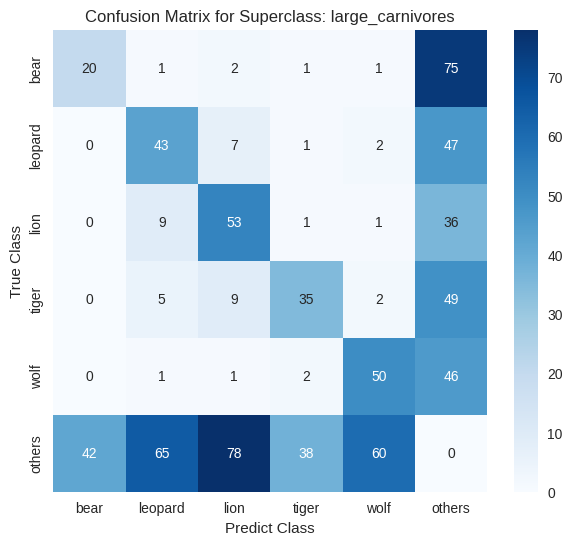

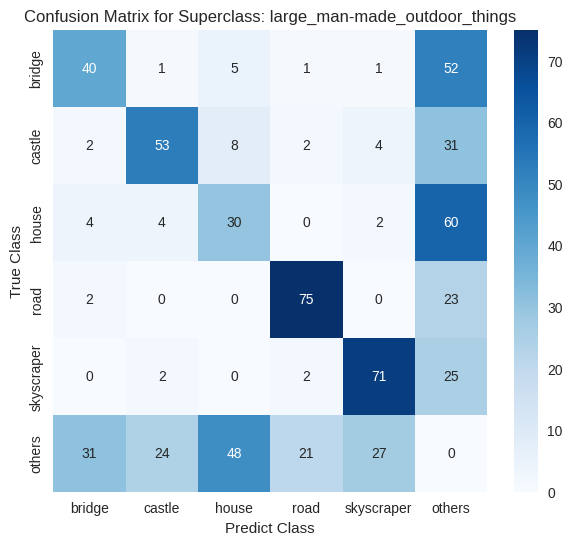

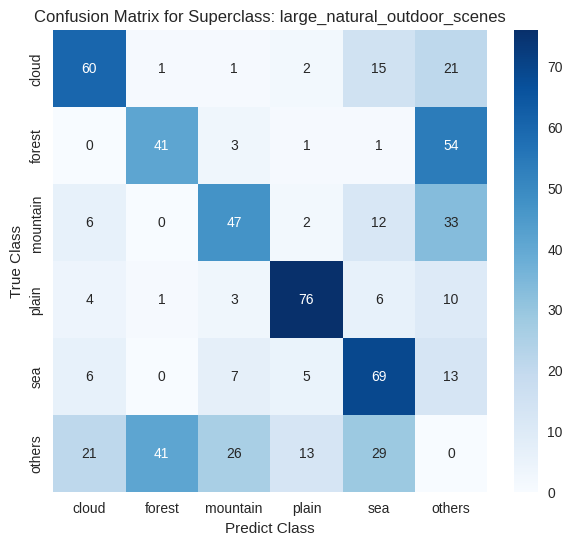

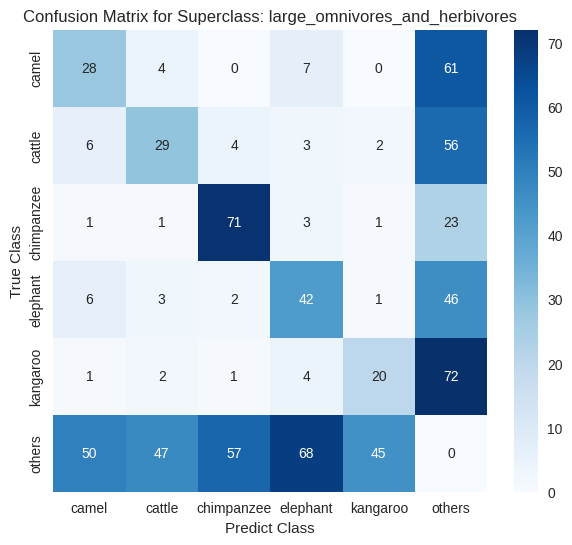

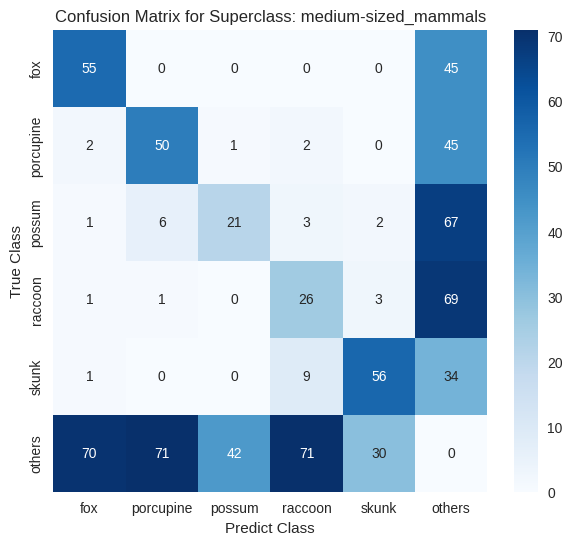

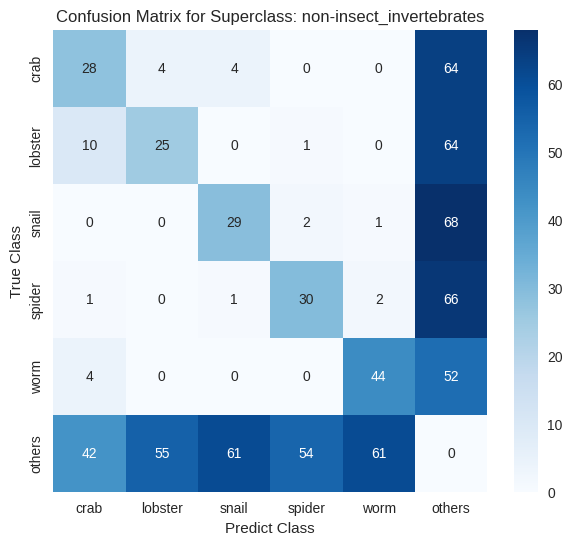

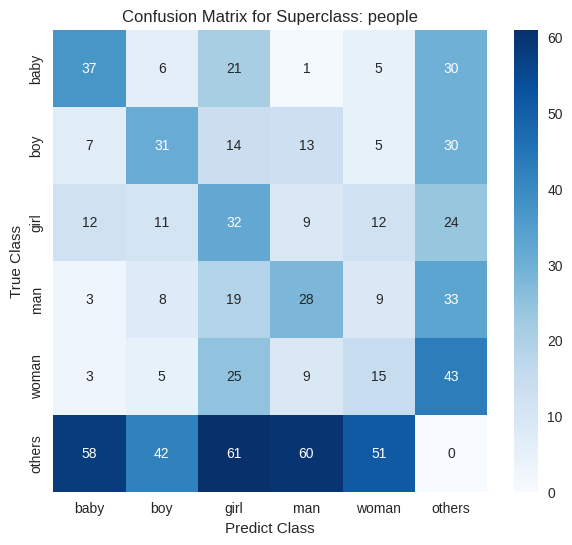

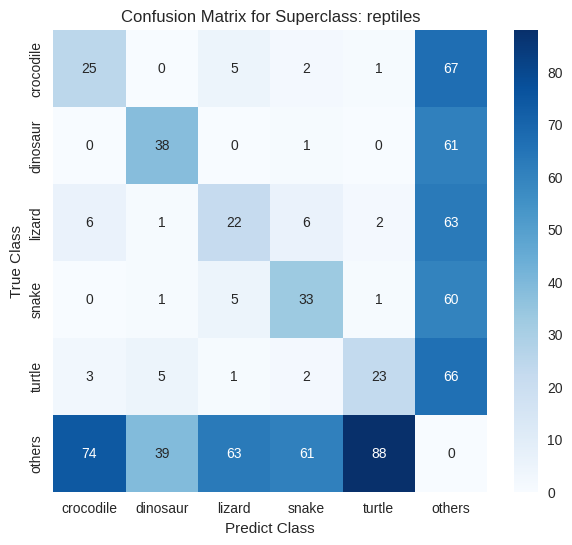

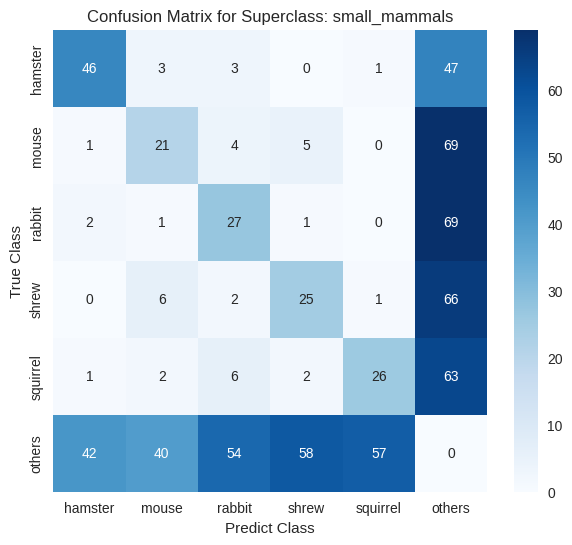

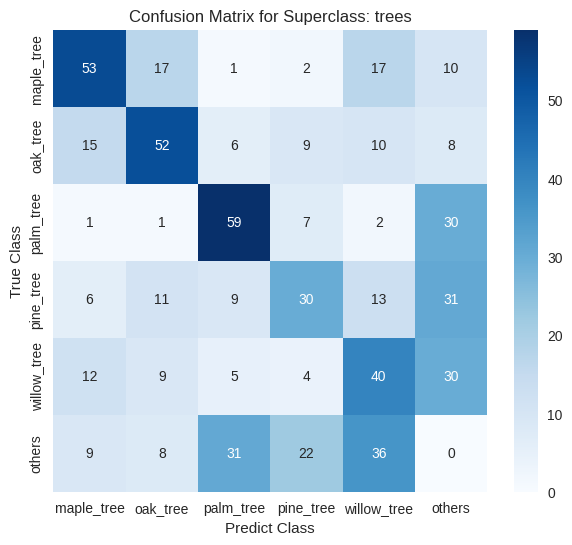

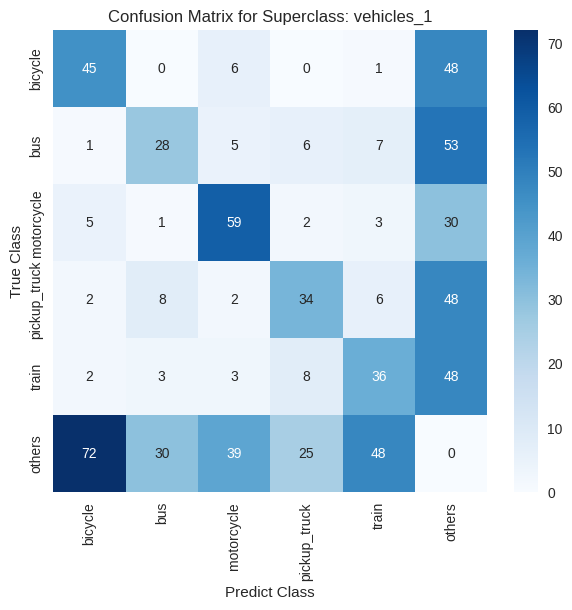

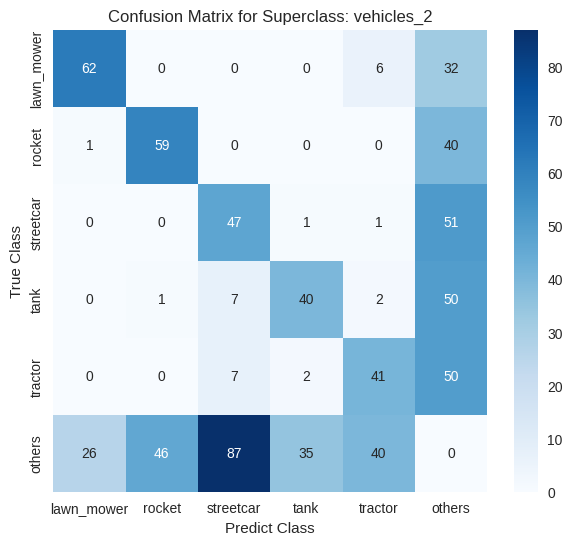

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("/kaggle/input/vit_v4/pytorch/default/1/VisionTransformer_CIFAR100_checkpoint (1).pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  35.92 M 
fwd MACs:                                                               76.1882 GMACs
fwd FLOPs:                                                              152.607 GFLOPS
fwd+bwd MACs:                                                           228.565 GMACs
fwd+bwd FLOPs:                                                          457.82 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod